In [ ]:
#!pip install biobss
#!pip uninstall matplotlib
!pip install --upgrade matplotlib

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.signal as sp
from sklearn.cluster import DBSCAN
import neurokit2 as nk
import biobss
import math

from Modules.Feature_Extraction import *

In [ ]:
def read_csv(filepath):
    signals = pd.read_csv(filepath, sep=',', header=None)

    return signals.to_numpy()


ecg = read_csv('Preprocessed_data/ecg/ecg_unfiltered.csv')
ecg_filt = read_csv('Preprocessed_data/ecg/ecg_filtered.csv')

#fs = read_csv('Preprocessed_data/fs/fs.csv')
fs  = [62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725, 62.4725]

In [5]:
#remove first and last few minutes

ecg_filt_cropped = []
for i in range(len(ecg_filt)):
    ecg_filt_cropped.append(ecg_filt[i][5000:763000])

ecg_cropped = []
for i in range(len(ecg)):
    ecg_cropped.append(ecg[i][5000:763000])

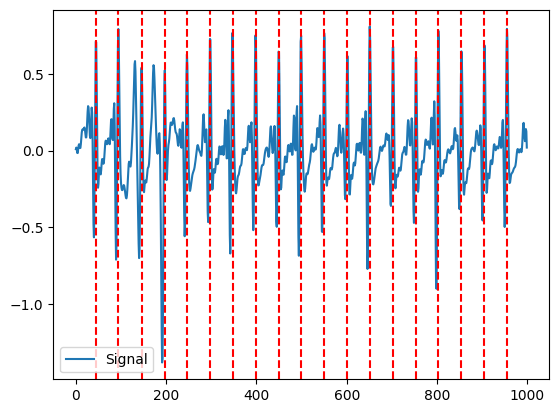

In [6]:
# Automatically process the (raw) ECG signal
signals, info = nk.ecg_process(ecg_filt_cropped[2][100000:101000], sampling_rate=125)

# Extract clean ECG and R-peaks location
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals["ECG_Clean"]

# Visualize R-peaks in ECG signal
plot = nk.events_plot(rpeaks, cleaned_ecg)

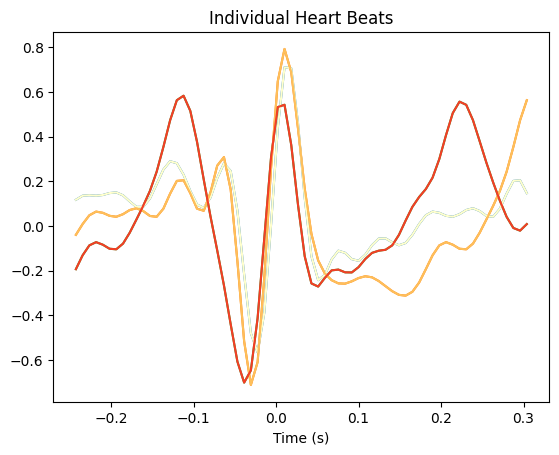

In [7]:
# Plotting all the heart beats
epochs = nk.ecg_segment(cleaned_ecg[0:250], rpeaks=None, sampling_rate=125, show=True)

In [10]:
def extract_heartbeats(cleaned, peaks, sampling_rate=None):
    heartbeats = nk.epochs_create(cleaned,
                                  events=peaks,
                                  epochs_start=-0.3,
                                  epochs_end=0.4,
                                  sampling_rate=sampling_rate)
    heartbeats = nk.epochs_to_df(heartbeats)
    return heartbeats

In [139]:
# Define a function to create epochs
signals, info = nk.ecg_process(ecg_filt_cropped[2], sampling_rate=125)

# Extract clean ECG and R-peaks location
rpeaks = info["ECG_R_Peaks"]
cleaned_ecg = signals["ECG_Clean"]

heartbeats = extract_heartbeats(cleaned_ecg, peaks=rpeaks, sampling_rate=125)
heartbeats_pivoted = heartbeats.pivot(index='Label', columns='Time', values='Signal')
heartbeats_pivoted.head()

D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: divide by zero encountered in divide
  mrrs /= th2
D:\Semester4\Guided Research\guided research\venv\lib\site-packages\neurokit2\signal\signal_fixpeaks.py:277: RuntimeWarning: invalid value encountered in divide
  mrrs /= th2


Time,-0.300000,-0.291954,-0.283908,-0.275862,-0.267816,-0.259770,-0.251724,-0.243678,-0.235632,-0.227586,...,0.327586,0.335632,0.343678,0.351724,0.359770,0.367816,0.375862,0.383908,0.391954,0.400000
Label,,,,,,,,,,,,,,,,,,,,,
1,-0.060107,-0.026373,-0.012578,-0.015603,-0.018478,-0.007026,0.018144,0.043766,0.056181,0.051866,...,-0.008898,-0.024067,-0.023233,-0.025210,-0.051624,-0.096345,-0.113457,-0.042621,0.140719,0.389070
10,-0.103000,-0.093285,-0.095173,-0.098985,-0.090446,-0.064948,-0.031856,-0.005889,0.005217,0.005204,...,-0.054106,-0.077401,-0.086447,-0.091270,-0.105878,-0.123717,-0.108059,-0.013687,0.171163,0.396476
100,-0.117188,-0.116242,-0.128989,-0.141658,-0.137554,-0.111689,-0.074135,-0.040911,-0.021980,-0.016697,...,-0.007261,-0.017763,-0.025725,-0.049245,-0.092353,-0.124710,-0.090873,0.049343,0.277493,0.507938
1000,-0.162838,-0.121836,-0.089221,-0.074579,-0.072405,-0.070614,-0.059493,-0.034120,0.007541,0.064527,...,-0.081512,-0.073406,-0.064575,-0.070899,-0.102574,-0.140871,-0.132706,-0.017458,0.225722,0.544325
10000,-0.386247,-0.394912,-0.410100,-0.404808,-0.352211,-0.250294,-0.125212,-0.013006,0.062388,0.097530,...,0.100002,0.031970,0.020928,0.075479,0.176923,0.292687,0.389655,0.439906,0.421975,0.325234


In [142]:
clustering = DBSCAN(eps=15, min_samples=10).fit(heartbeats_pivoted)
DBSCAN_dataset = heartbeats_pivoted.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_

DBSCAN_dataset.Cluster.value_counts().to_frame()

,count
Cluster,
0,14521
-1,10


Text(0.5, 1.0, 'DBSCAN')

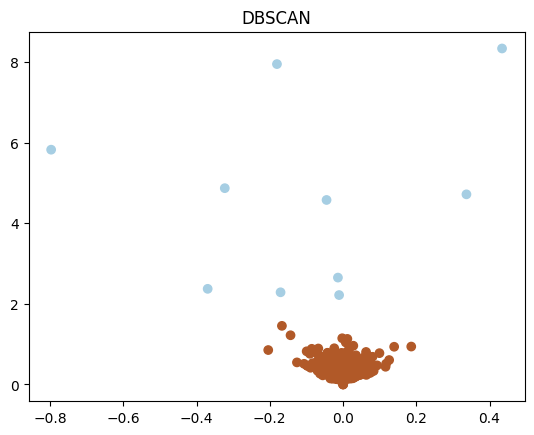

In [143]:
y_pred = clustering.fit_predict(heartbeats_pivoted)

heartbeats_pivoted[100] = heartbeats_pivoted.mean(axis=1)
heartbeats_pivoted[101] = heartbeats_pivoted.std(axis=1)

plt.scatter(heartbeats_pivoted[100], heartbeats_pivoted[101],c=y_pred, cmap='Paired')
plt.title("DBSCAN")


In [144]:
anomoly_indices = np.where(y_pred == -1)

anomolous_heartbeats = np.take(heartbeats_pivoted, anomoly_indices[0], 0)
anomolous_heartbeats = anomolous_heartbeats.drop([100, 101], axis=1).T
anomolous_heartbeats

Label,201,202,7840,7841,7843,7900,7901,7902,8339,907
Time,,,,,,,,,,
-0.300000,-0.254439,0.161389,-3.245288,2.447760,0.962430,-5.013969,0.188693,-0.358906,-1.167059,0.398743
-0.291954,-0.236588,0.177945,-3.502221,1.937868,1.046098,-6.123631,0.534875,-0.486523,-1.255518,0.456912
-0.283908,-0.212338,0.259467,-3.389940,1.258144,1.153879,-5.890692,1.026300,-0.660566,-1.268572,0.517905
-0.275862,-0.200235,0.354921,-2.897567,0.526950,1.283204,-4.182560,1.505159,-0.812830,-1.215006,0.604419
-0.267816,-0.204741,0.393463,-2.262929,-0.216615,1.401271,-1.602873,1.846449,-0.887642,-1.174232,0.766088
...,...,...,...,...,...,...,...,...,...,...
0.367816,-12.832698,-0.204318,-0.287695,0.250892,-1.351052,5.396192,-10.342075,-0.299086,0.912749,-0.270066
0.375862,-11.853975,-0.227104,-0.182477,0.049044,-0.563045,5.217365,-18.748406,-0.350636,0.971873,-0.415929
0.383908,-7.115133,-0.270912,0.145013,-0.146664,0.266188,5.028894,-26.358616,-0.409088,1.016286,-0.544288


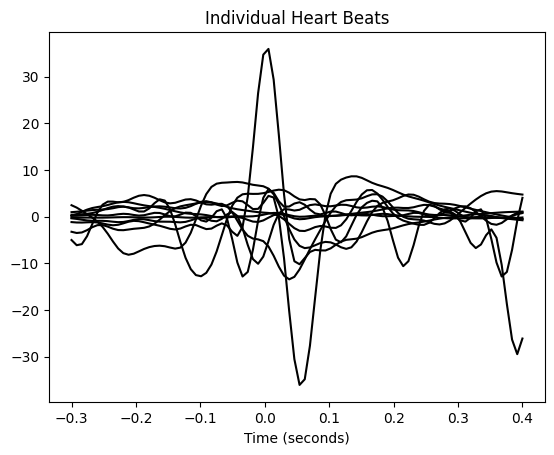

In [145]:
# Prepare figure
fig, ax = plt.subplots()

ax.set_title("Individual Heart Beats")
ax.set_xlabel("Time (seconds)")

# Aesthetics
labels = list(anomolous_heartbeats)
lines = [] # Create empty list to contain the plot of each signal

for i, x in zip(labels, anomolous_heartbeats):
    line, = ax.plot(anomolous_heartbeats[x], label='%s' % i, color="black")
    lines.append(line)

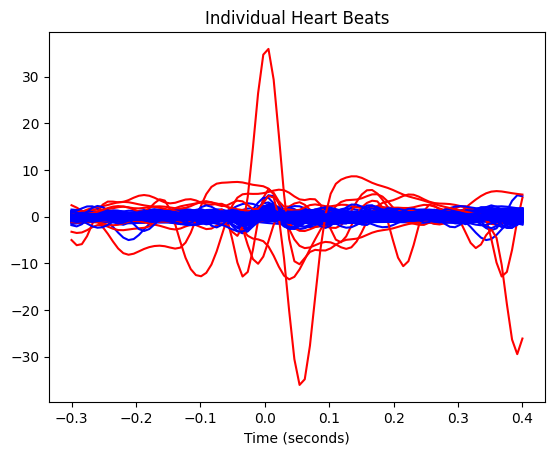

In [146]:
heartbeats_pivoted = heartbeats_pivoted.drop([100, 101], axis=1).T

# Prepare figure
fig, ax = plt.subplots()

ax.set_title("Individual Heart Beats")
ax.set_xlabel("Time (seconds)")

# Aesthetics
labels = list(heartbeats_pivoted)
lines = [] # Create empty list to contain the plot of each signal
colors = {0: "blue", -1: "red"}

for i, x, z in zip(labels, heartbeats_pivoted, y_pred):
    line, = ax.plot(heartbeats_pivoted[x], label='%s' % i, c=colors[z])
    lines.append(line)

In [14]:
heartbeats = extract_heartbeats(cleaned_ecg, peaks=rpeaks, sampling_rate=125)
heartbeats_pivoted = heartbeats.pivot(index='Label', columns='Time', values='Signal')

clustering = DBSCAN(eps=2, min_samples=10).fit(heartbeats_pivoted)
DBSCAN_dataset = heartbeats_pivoted.copy()
DBSCAN_dataset.loc[:,'Cluster'] = clustering.labels_

DBSCAN_dataset.Cluster.value_counts().to_frame()

,count
Cluster,
0,17
-1,2


Text(0.5, 1.0, 'DBSCAN')

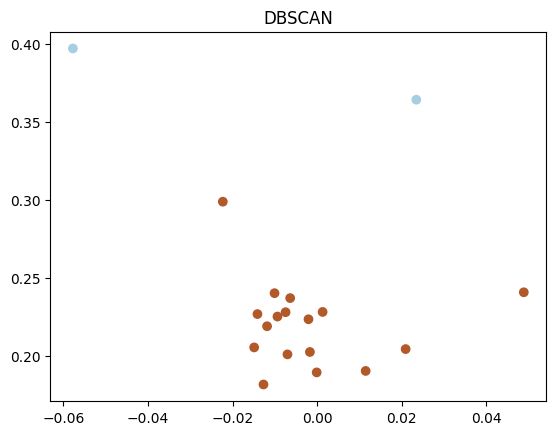

In [15]:
y_pred = clustering.fit_predict(heartbeats_pivoted)

heartbeats_pivoted[100] = heartbeats_pivoted.mean(axis=1)
heartbeats_pivoted[101] = heartbeats_pivoted.std(axis=1)

plt.scatter(heartbeats_pivoted[100], heartbeats_pivoted[101],c=y_pred, cmap='Paired')
plt.title("DBSCAN")

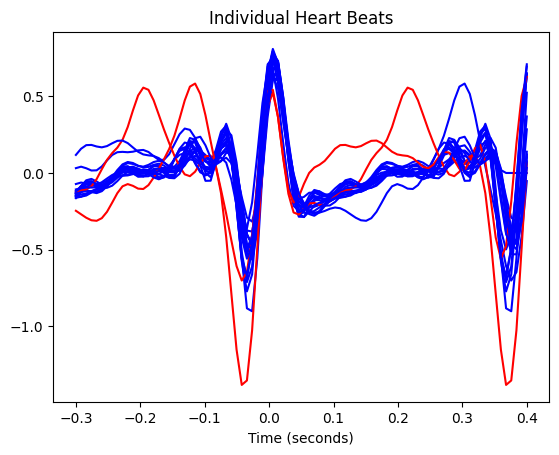

In [17]:
anomoly_indices = np.where(y_pred == -1)

anomolous_heartbeats = np.take(heartbeats_pivoted, anomoly_indices[0], 0)
anomolous_heartbeats = anomolous_heartbeats.drop([100, 101], axis=1).T

heartbeats_pivoted = heartbeats_pivoted.drop([100, 101], axis=1).T

# Prepare figure
fig, ax = plt.subplots()

ax.set_title("Individual Heart Beats")
ax.set_xlabel("Time (seconds)")

# Aesthetics
labels = list(heartbeats_pivoted)
lines = [] # Create empty list to contain the plot of each signal
colors = {0: "blue", -1: "red"}

for i, x, z in zip(labels, heartbeats_pivoted, y_pred):
    line, = ax.plot(heartbeats_pivoted[x], label='%s' % i, c=colors[z])
    lines.append(line)